In [1]:
import pandas as pd
from collections import defaultdict, Counter
from itertools import product
import json
import re
import numpy as np
import sys
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

pd.set_option('display.max_columns', None) # visualize all columns in console
np.set_printoptions(precision=2)

Using TensorFlow backend.


# StructuredPerceptron CLASS 

In [23]:
class StructuredPerceptron(object):
    """
    implements a structured perceptron as described in Collins 2002,
    with updates from https://explosion.ai/blog/part-of-speech-pos-tagger-in-python
    """
    
    def __init__(self):
        """
        initialize model parameters
        """
        self.tags = set()
        self.feature_weights = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        self.weight_totals = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight
        self.timestamps = defaultdict(lambda: defaultdict(float)) #feature_name -> tags -> weight

        self.tag_dict = defaultdict(set) #word -> {tags}

        self.START = "__START__"
        self.END = "__END__"
        
        
    #def normalize(self, word):
    #    """
    #    lowercase word, and replace numbers, user names, and URLs
    #    """
    #    return re.sub(urls, 'URL', re.sub(users, '@USER', re.sub(numbers, '0', word.strip().lower())))

    
    def evaluate(self, data_instances, predict_method='greedy'):
        correct = 0
        total = 0
        for (words, tags) in tqdm(data_instances):
            preds = self.predict(words, method=predict_method)
            matches = sum(map(lambda x: int(x[0]==x[1]), zip(preds, tags)))
            correct += matches
            total += len(tags)
        return correct/total
        
    
    def fit(self, instances, dev_instances, iterations=10, learning_rate=0.25, inference='greedy', verbose=False):
        """
        read in a CoNLL-format file, extract features to train weight vector
        """        
        
        #instances = [(words, tags) for (words, tags) in self.read_conll_file(file_name)]
        
        # initialize tag dictionary for each word and get tag set
        for (words, tags) in instances:
            self.tags.update(set(tags))

            for word, tag in zip(words, tags):
                self.tag_dict[np.array_str(word)].add(tag)
        
        #if dev_file:
        #    dev_instances = [(words, tags) for (words, tags) in self.read_conll_file(dev_file)]
            
        # iterate over data
        for iteration in range(1, iterations+1):
            correct = 0
            total = 0
            if verbose:
                print('Iteration {}'.format(iteration), file=sys.stderr, flush=True)
                print("*" * 15, file=sys.stderr, flush=True)

            random.shuffle(instances)
            for i, (words, tags) in enumerate(instances):
                if i > 0:
                    if i%1000==0:
                        print('%s'%i, file=sys.stderr, flush=True)
                    elif i%20==0:
                        print('.', file=sys.stderr, flush=True, end='')

                # get prediction
                prediction = self.predict(words, method=inference)

                # derive global features
                global_gold_features, global_prediction_features = self.get_global_features(words, prediction, tags)
                                    
                # update weight vector:
                # 1. move closer to true tag
                for tag, fids in global_gold_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] += learning_rate * count

                # 2. move further from wrong tag
                for tag, fids in global_prediction_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] -= learning_rate * count
                        
                # compute training accuracy for this iteration
                correct += sum([int(predicted_tag == true_tag) for predicted_tag, true_tag in zip(prediction, tags)])
                total += len(tags)

                # output examples
                if verbose and i%1000==0:
                    print("current word accuracy:{:.2f}".format(correct/total))
                    #print(list(zip(words, 
                    #               [word for word in words], 
                    #               tags, 
                    #               prediction)), file=sys.stderr, flush=True)
            
            print('\t{} features'.format(len(self.feature_weights)), file=sys.stderr, flush=True)
            print('\tTraining accuracy: {:.2f}\n'.format(correct/total), file=sys.stderr, flush=True)
        
        if dev_instances:
            print('\tDevelopment accuracy: {:.2f}\n'.format(self.evaluate(dev_instances, predict_method=inference)), file=sys.stderr, flush=True)
         
        # average weights
        for feature, tags in self.feature_weights.items():
            for tag in tags:
                total = self.weight_totals[feature][tag]
                total += (iterations - self.timestamps[feature][tag]) * self.feature_weights[feature][tag]
                averaged = round(total / float(iterations), 3)
                self.feature_weights[feature][tag] = averaged


    """
    def get_features(self, word, previous_tag2, previous_tag, words, i):
        
        'get all features that can be derived from the word and previous tags'
        
        prefix = word[:3]
        suffix = word[-3:]

        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    #'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    #'PREV_TAG={}'.format(previous_tag),                 # previous tag
                    #'PREV_TAG2={}'.format(previous_tag2),                 # two-previous tag
                    #'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),  # tag bigram
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),            # word-tag combination
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),        # prefix and tag
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),        # suffix and tag
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
                    'BIAS'
            }
        return features
        """
    
    
    def get_features(self, word, previous_tag2, previous_tag, words, idx):
        
        ## RECALL THAT word==PIXELS, tag==LETTER AND words==ACTUAL_WORD (in the latter, ACTUAL_WORD is indeed the word where the letter is currently occurring)
        
        # pixel values for letter
        word_pixel_ids = [f'p_{i}_{j}' for i,j in product(range(16), range(8))]
        features = {
            f"{pixel_id}={pixel_value}" for pixel_id, pixel_value in zip(word_pixel_ids, word)
        }
        
        # get other features for word and context, and add them to the dictionary
        new_features = {
            'PREV_TAG={}'.format(previous_tag),                 
            'PREV_TAG2={}'.format(previous_tag2),
            'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),
            'WORD_PIXCOUNT_MORE_UPPER={}'.format(word.reshape(16, -1)[:8,:].sum() > word.reshape(16, -1)[8:,:].sum())
        }
        features.update(new_features)
        
        # pixel values for one previous and two subsequent letters
        if words[idx-1] == self.START:
            features.add('PREV_WORD={}'.format(words[idx-1]))
        else:
            features.add('PWORD_PIXCOUNT_MORE_UPPER={}'.format(words[idx-1].reshape(16, -1)[:8,:].sum() > words[idx-1].reshape(16, -1)[8:,:].sum()))
            previous_word_pixel_ids = [f'pword_p_{i}_{j}' for i,j in product(range(16), range(8))]
            for pixel_id, pixel_value in zip(previous_word_pixel_ids, words[idx-1]):
                features.add(f"{pixel_id}={pixel_value}")
        
        #if words[idx-2] == self.START:
        #    features.add('PREV_WORD2={}'.format(words[idx-2]))
        #else:
        #    features.add('PWORD2_PIXCOUNT_MORE_UPPER={}'.format(words[idx-2].reshape(16, -1)[:8,:].sum() > words[idx-2].reshape(16, -1)[8:,:].sum()))
        #    previous_word2_pixel_ids = [f'pword2_p_{i}_{j}' for i,j in product(range(16), range(8))]
        #    for pixel_id, pixel_value in zip(previous_word2_pixel_ids, words[idx-2]):
        #        features.add(f"{pixel_id}={pixel_value}")
        
        if words[idx+1] == self.END:
            features.add('NEXT_WORD={}'.format(words[idx+1]))
        else:
            features.add('NWORD_PIXCOUNT_MORE_UPPER={}'.format(words[idx+1].reshape(16, -1)[:8,:].sum() > words[idx+1].reshape(16, -1)[8:,:].sum()))
            next_word_pixel_ids = [f'nword_p_{i}_{j}' for i,j in product(range(16), range(8))]
            for pixel_id, pixel_value in zip(next_word_pixel_ids, words[idx+1]):
                features.add(f"{pixel_id}={pixel_value}")
                
        if words[idx+2] == self.END:
            features.add('NEXT_WORD2={}'.format(words[idx+2]))
        else:
            features.add('NWORD2_PIXCOUNT_MORE_UPPER={}'.format(words[idx+2].reshape(16, -1)[:8,:].sum() > words[idx+2].reshape(16, -1)[8:,:].sum()))
            next_word2_pixel_ids = [f'nword2_p_{i}_{j}' for i,j in product(range(16), range(8))]
            for pixel_id, pixel_value in zip(next_word2_pixel_ids, words[idx+2]):
                features.add(f"{pixel_id}={pixel_value}")
        
        
        return features
        
    
    def get_global_features(self, words, predicted_tags, true_tags):
        '''
        sum up local features
        '''
        context = [self.START] + [word for word in words] + [self.END, self.END]

        global_gold_features = defaultdict(lambda: Counter())
        global_prediction_features = defaultdict(lambda: Counter())

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START
        
        for j, (word, predicted_tag, true_tag) in enumerate(zip(words, predicted_tags, true_tags)):
            # get the predicted features. NB: use j+1, since context is longer than words
            prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)

            # update feature correlation with true and predicted tag
            global_prediction_features[predicted_tag].update(prediction_features)
            global_gold_features[true_tag].update(prediction_features)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

        return global_gold_features, global_prediction_features
            
    
    def get_scores(self, features):
        """
        predict scores for each tag given features
        """
        scores = defaultdict(float)
        
        # add up the scores for each tag
        for feature in features:
            if feature not in self.feature_weights:
                continue
            weights = self.feature_weights[feature]
            for tag, weight in weights.items():
                scores[tag] += weight

        # return tag scores
        if not scores:
            # if there are no scores (e.g., first iteration),
            # simply return the first tag with score 1
            scores[list(self.tags)[0]] = 1
        
        return scores


    def predict(self, words, method='greedy'):
        '''
        predict tags using one of two methods
        '''
        if method == 'greedy':
            return self.predict_greedy(words)
        elif method == 'viterbi':
            return self.predict_viterbi(words)

    
    def predict_viterbi(self, words):
        '''
        predict using Viterbi decoding
        '''
        context = [self.START] + [word for word in words] + [self.END, self.END]

        N = len(words)
        M = len(self.tags) #number of tags
        tags = sorted(self.tags)

        # create trellis of size M (number of tags) x N (sentence length)
        Q = np.ones((M, N)) * float('-Inf')
        backpointers = np.ones((M, N), dtype=np.int16) * -1 #backpointers

        # initialize probs for tags j at position 1 (first word)
        features = self.get_features(words[0], self.START, self.START, context, 1)
        scores = self.get_scores(features)
        allowed_initial_tags = self.tag_dict[np.array_str(context[1])]

        for j in range(M):
            if not allowed_initial_tags or tags[j] in allowed_initial_tags:
                Q[j,0] = scores[tags[j]]

        # filling the lattice, for every position and every tag find viterbi score Q
        for i in range(1, N):
            allowed_tags = self.tag_dict[np.array_str(context[i+1])]

            # for every previous tag
            for j in range(M):
                best_score = 0.0#float('-Inf')
                prev_tag = tags[j]

                # skip impossible tags
                allowed_previous_tags = self.tag_dict[np.array_str(context[i])]
                if allowed_previous_tags and prev_tag not in allowed_previous_tags:
                    continue

                best_before = Q[j,i-1] # score of previous tag

                # for every possible pre-previous tag
                for k in range(M):
                    if i == 1:
                        prev2_tag = self.START
                    else:
                        prev2_tag = tags[k]
                        # skip impossible tags
                        allowed_previous2_tags = self.tag_dict[np.array_str(context[i-1])]
                        if allowed_previous2_tags and prev2_tag not in allowed_previous2_tags:
                            continue

                    # get features of word i with the two previous tags
                    features = self.get_features(words[i], prev2_tag, prev_tag, context, i+1)
                    scores = self.get_scores(features)

                    # update best score
                    for t in range(M):
                        tag = tags[t]
                        # if word is unknown, use all tags, otherwise allowed ones
                        if not allowed_tags or tag in allowed_tags:
                            tag_score = best_before + scores[tag]

                            if tag_score > best_score:
                                Q[t,i] = tag_score
                                best_score = tag_score
                                backpointers[t,i] = j

        # final best
        best_id = Q[:,-1].argmax()

        # print best tags in reverse order
        predtags = [tags[best_id]]

        for i in range(N-1,0,-1):
            idx = backpointers[best_id, i]
            predtags.append(tags[idx])
            best_id = idx

        #return reversed predtags
        return predtags[::-1]         

    
    def predict_greedy(self, words):
        '''
        greedy prediction
        '''
        context = [self.START] + [word for word in words] + [self.END, self.END]
                
        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START

        out = []

        for j, word in enumerate(words):
            # for unambiguous words, just look up the tag
            predicted_tag = \
                list(self.tag_dict[np.array_str(context[j+1])])[0] if len(self.tag_dict[np.array_str(context[j+1])]) == 1 else None

            if not predicted_tag:
                # get the predicted features. NB: use j+1, since context is longer than words
                prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)
                scores = self.get_scores(prediction_features)
                
                # predict the current tag
                predicted_tag = max(scores, key=scores.get)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

            out.append(predicted_tag)

        return out
    
        
    def read_conll_file(self, file_name):
        """
        read in a file with CoNLL format:
        word1    tag1
        word2    tag2
        ...      ...
        wordN    tagN

        Sentences MUST be separated by newlines!
        """
        current_words = []
        current_tags = []

        with open(file_name, encoding='utf-8') as conll:
            for line in conll:
                line = line.strip()

                if line:
                    word, tag = line.split('\t')
                    current_words.append(word)
                    current_tags.append(tag)

                else:
                    yield (current_words, current_tags)
                    current_words = []
                    current_tags = []

        # if file does not end in newline (it should...), check whether there is an instance in the buffer
        if current_tags != []:
            yield (current_words, current_tags)
        

    def save(self, file_name):
        """
        save model as pickle file
        """
        print("saving model...", end=' ', file=sys.stderr)
        with open(file_name, "wb") as model:
            # pickle cannot save default_dictionaries
            # => make copy and turn into regular dictionaries
            save_feature_weights = defaultdict(lambda: defaultdict(float))
            save_feature_weights.update(self.feature_weights)
            save_tag_dict = defaultdict(set)
            save_tag_dict.update(self.tag_dict)

            save_feature_weights.default_factory = None
            save_tag_dict.default_factory = None
            pickle.dump((save_feature_weights, save_tag_dict, self.tags),
                     model, -1)
        print("done", file=sys.stderr)


    def load(self, file_name):
        """
        load model from pickle file
        """
        print("loading model...", end=' ', file=sys.stderr)
        with open(file_name, 'rb') as model:
            try:
                parameters = pickle.load(model)
            except IOError:
                msg = ("No such model file.")
                raise MissingCorpusError(msg)

            feature_weights, tag_dict, tags = parameters
            self.tags = tags

            # pickle cannot store defaultdicts, so we need a 2-step process
            # 1. initialize
            self.feature_weights = defaultdict(lambda: defaultdict(float))
            self.tag_dict = defaultdict(set)
            
            # 2. update
            self.feature_weights.update(feature_weights)
            self.tag_dict.update(tag_dict)
        print("done", file=sys.stderr)
        return None

# Data preparation 

In [2]:
columns = ['id', 'letter', 'next_id', 'word_id', 'in_word_position', 'cv_fold'] +\
            [f'p_{i}_{j}' for i,j in product(range(16), range(8))] + ['Unnamed: 134']

In [3]:
digits_data = pd.read_csv('/Users/lucamasserano/Desktop/BOCCONI/nlp/final_project/lyrics_project/data/letter_data', 
                          sep='\t', header=None, names=columns).drop(columns='Unnamed: 134')
digits_data.shape

(52152, 134)

In [4]:
digits_data.head(10)

,id,letter,next_id,word_id,in_word_position,cv_fold,p_0_0,p_0_1,p_0_2,p_0_3,p_0_4,p_0_5,p_0_6,p_0_7,p_1_0,p_1_1,p_1_2,p_1_3,p_1_4,p_1_5,p_1_6,p_1_7,p_2_0,p_2_1,p_2_2,p_2_3,p_2_4,p_2_5,p_2_6,p_2_7,p_3_0,p_3_1,p_3_2,p_3_3,p_3_4,p_3_5,p_3_6,p_3_7,p_4_0,p_4_1,p_4_2,p_4_3,p_4_4,p_4_5,p_4_6,p_4_7,p_5_0,p_5_1,p_5_2,p_5_3,p_5_4,p_5_5,p_5_6,p_5_7,p_6_0,p_6_1,p_6_2,p_6_3,p_6_4,p_6_5,p_6_6,p_6_7,p_7_0,p_7_1,p_7_2,p_7_3,p_7_4,p_7_5,p_7_6,p_7_7,p_8_0,p_8_1,p_8_2,p_8_3,p_8_4,p_8_5,p_8_6,p_8_7,p_9_0,p_9_1,p_9_2,p_9_3,p_9_4,p_9_5,p_9_6,p_9_7,p_10_0,p_10_1,p_10_2,p_10_3,p_10_4,p_10_5,p_10_6,p_10_7,p_11_0,p_11_1,p_11_2,p_11_3,p_11_4,p_11_5,p_11_6,p_11_7,p_12_0,p_12_1,p_12_2,p_12_3,p_12_4,p_12_5,p_12_6,p_12_7,p_13_0,p_13_1,p_13_2,p_13_3,p_13_4,p_13_5,p_13_6,p_13_7,p_14_0,p_14_1,p_14_2,p_14_3,p_14_4,p_14_5,p_14_6,p_14_7,p_15_0,p_15_1,p_15_2,p_15_3,p_15_4,p_15_5,p_15_6,p_15_7
0,1,o,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,m,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,0,1,1,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,m,4,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,a,5,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,n,6,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,d,7,1,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,0,1,1,0,1,0,1,1,0,1,0,0,1,1,1,0,0,1,0,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0
6,7,i,8,1,7,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
7,8,n,9,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,9,g,-1,1,9,0,0,1,1,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
9,10,o,11,2,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Example of rasterized digit (16x8 pixels)

In [5]:
index = 9832

In [6]:
d = digits_data.iloc[index, 6:].to_numpy().reshape(16, -1).astype('int')

Corresponding letter:  h 



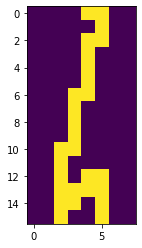

In [7]:
print('Corresponding letter: ', digits_data.loc[index, 'letter'], '\n')
plt.imshow(d)
plt.show()

#### Create (words, tags):(pixel_arrays, letters) tuples. The fit() method will be fed with these instances.

In [8]:
words_tags = []
current_word = []
current_tags = []
for row in tqdm(digits_data.iterrows()):
    current_word.append(row[1][6:].to_numpy().astype('int'))
    current_tags.append(row[1].letter)
    if row[1].next_id == -1:
        words_tags.append((current_word, current_tags))
        current_word = []
        current_tags = []

52152it [00:16, 3211.46it/s]


In [9]:
words_tags[6777][1]

['c', 'k', 'n', 'o', 'w', 'l', 'e', 'd', 'g', 'e', 'm', 'e', 'n', 't']

#### Divide in train and dev

In [11]:
idxs = [i for i in range(len(words_tags))]
random.shuffle(idxs)

words_tags = np.array(words_tags)[idxs].tolist()
words_tags[6777][1]

['a', 'x', 'i']

In [12]:
train_frac, dev_frac = 0.7, 0.15
N = len(words_tags)

train = words_tags[:int(N*train_frac)]
dev = words_tags[int(N*train_frac):int(N*train_frac)+int(N*dev_frac)]
test = words_tags[int(N*train_frac)+int(N*dev_frac):]

len(train), len(dev), len(test)

(4813, 1031, 1033)

# Structured Perceptron

In [30]:
sp = StructuredPerceptron()

In [31]:
inference_method = 'viterbi'
%time sp.fit(instances=train, dev_instances=dev, iterations=2, inference=inference_method, verbose=True)

Iteration 1
***************
/Users/lucamasserano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:198: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/lucamasserano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:206: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/lucamasserano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


current word accuracy:0.00


.................................................1000


current word accuracy:0.87


.................................................2000


current word accuracy:0.88


.................................................3000


current word accuracy:0.88


.................................................4000


current word accuracy:0.89


........................................	1301 features
	Training accuracy: 0.88

Iteration 2
***************


current word accuracy:1.00


.................................................1000


current word accuracy:0.89


.................................................2000


current word accuracy:0.89


.................................................3000


current word accuracy:0.88


.................................................4000


current word accuracy:0.89


........................................	1302 features
	Training accuracy: 0.88

100%|██████████| 1031/1031 [3:21:38<00:00, 11.51s/it] 
	Development accuracy: 0.13



CPU times: user 3h 55min 45s, sys: 4min 42s, total: 4h 28s
Wall time: 3h 56min 5s


In [32]:
sp.save('model_viterbi.pickle')

saving model... done


In [33]:
with open('./model_viterbi.pickle', 'rb') as pickled_obj:
    sp_viterbi = pickle.load(pickled_obj)

In [35]:
sp_viterbi

In [ ]:
sp = StructuredPerceptron()
inference_method = 'greedy'
%time sp.fit('./data/tiny_POS_train.data', dev_file='../data/tiny_POS_test.data', iterations=10, inference=inference_method)
sp.save('model_greedy.pickle')

# Bi-LSTM

#### Divide in train and dev

In [78]:
idxs = [i for i in range(len(words_tags))]
random.shuffle(idxs)

words_tags = np.array(words_tags)[idxs].tolist()
words_tags[6777][1]

['g', 'o', 'n', 'i', 'z', 'i', 'n', 'g', 'l', 'y']

In [79]:
train_fraction = 0.8
N = len(words_tags)

train_instances = words_tags[:int(N*train_fraction)]
test_instances = words_tags[int(N*train_fraction):]

len(train_instances), len(test_instances)

(5501, 1376)

#### Model 

In [80]:
# collect known tags
tagset = set()
for (words, tags) in train_instances:
    tagset.update(set(tags))

# map tags into ints
PAD = '-PAD-' 
tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0
# to translate it back
int2tag = {i:tag for tag, i in tag2int.items()}

def convert2ints(instances):
    result = []
    for (words, tags) in instances:
        # replace tags with int
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((words, tag_ints))
    return result  

In [81]:
# apply integer mapping
train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

# separate the words from the tags
train_sentences, train_tags = zip(*train_instances_int) 
test_sentences, test_tags = zip(*test_instances_int) 

print(train_sentences[0])
print(train_tags[0])

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 

In [82]:
# get longest training sentence and add 10 (words are much variable in length: from (t)axi to (a)cknowledgement)
MAX_LENGTH = len(max(train_instances[0], key=len)) + 10
print(MAX_LENGTH)

24


In [83]:
# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences[0])
print(train_tags[0])

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[14  3 15 14 19  5 17 21  5 14 20  9  1 12  0  0  0  0  0  0  0  0  0  0]


In [84]:
# Set a random seed for reproducibility
np.random.seed(42)

inputs = Input((MAX_LENGTH, 128), # 128 = 16 x 18 x n_channels, but here n_channels=1 since the image is in gray scale
               name='word_pixel_arrays')
lstm = LSTM(units=256,
            return_sequences=True,
            name="LSTM")(inputs)
dropout = Dropout(0.3, name='dropout')(lstm)
lstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(lstm_out)

model = Model(inputs=[inputs], outputs=[output])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_pixel_arrays (InputLaye (None, 24, 128)           0         
_________________________________________________________________
LSTM (LSTM)                  (None, 24, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 24, 256)           0         
_________________________________________________________________
output (Dense)               (None, 24, 27)            6939      
_________________________________________________________________
softmax (Activation)         (None, 24, 27)            0         
Total params: 401,179
Trainable params: 401,179
Non-trainable params: 0
_________________________________________________________________


In [85]:
train_tags_1hot = to_categorical(train_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))

In [86]:
batch_size = 32
epochs = 5

# compile the model we have defined above
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 4400 samples, validate on 1101 samples
Epoch 1/5
4400/4400 [==============================] - 11s 2ms/step - loss: 0.9292 - accuracy: 0.7627 - val_loss: 0.5375 - val_accuracy: 0.8563
Epoch 2/5
4400/4400 [==============================] - 10s 2ms/step - loss: 0.4261 - accuracy: 0.8839 - val_loss: 0.3088 - val_accuracy: 0.9175
Epoch 3/5
4400/4400 [==============================] - 10s 2ms/step - loss: 0.2839 - accuracy: 0.9221 - val_loss: 0.2299 - val_accuracy: 0.9379
Epoch 4/5
4400/4400 [==============================] - 11s 2ms/step - loss: 0.2205 - accuracy: 0.9395 - val_loss: 0.1855 - val_accuracy: 0.9496
Epoch 5/5
4400/4400 [==============================] - 10s 2ms/step - loss: 0.1793 - accuracy: 0.9501 - val_loss: 0.1561 - val_accuracy: 0.9575


In [89]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

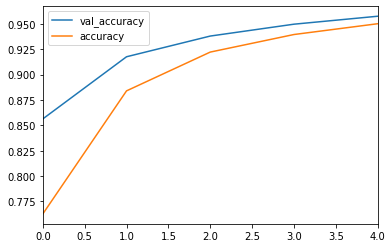

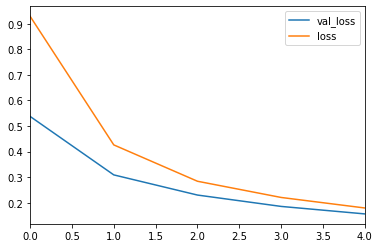

In [90]:
%matplotlib inline
import pandas as pd
import seaborn

df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [91]:
loss, accuracy = model.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

1376/1376 [==============================] - 1s 758us/step
Test loss: 0.1635373967678048
Test accuracy: 0.9545784592628479


In [94]:
predictions = model.predict(test_sentences)

In [123]:
def inverse_transform(sentences, predictions):
    output = []
    for sentence, prediction in zip(sentences, predictions):
        # find the index of the highest-scoring tag and translate it back
        token_sequence = [int2tag[np.argmax(prediction[i])] for i in range(len(sentence))]
        output.append(token_sequence)
    return output

result = list(zip(
    [[int2tag[idx] for idx in array if idx != 0] for array in test_tags], 
    [[tag for tag in array if tag != '-PAD-'] for array in inverse_transform(test_tags_1hot, predictions)]
))

In [133]:
result[1039]

(['c', 'c', 'o', 'u', 'n', 't', 'a', 'b', 'i', 'l', 'i', 't', 'y'],
 ['e', 'c', 'o', 'u', 'n', 't', 'a', 'b', 'i', 'l', 'i', 't', 'y'])